# CPSC 330 - Applied Machine Learning 

## Homework 4: Logistic regression, hyperparameter optimization 
### Associated lectures: [Lectures 7, 8](https://github.com/UBC-CS/cpsc330-2023s/tree/main/lectures) 

**Due Feb 12, 11:59pm: See the [Calendar](https://github.com/UBC-CS/cpsc330-2023W2/tree/main?tab=readme-ov-file#deliverable-due-dates-tentative).**

# Imports 

In [1]:
from hashlib import sha1
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

# Instructions
<hr>

_points: 4_

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023W2/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

# <br><br><br><br>

# Exercise 1: implementing `DummyClassifier`
<hr>

_points: 10_

In this course (unlike CPSC 340) you will generally **not** be asked to implement machine learning algorihtms (like logistic regression) from scratch. However, this exercise is an exception: you will implement the simplest possible classifier, `DummyClassifier`.
 
As a reminder, `DummyClassifier` is meant as a baseline and is generally a simple "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more 0s than 1s it predicts 0 every time, and if there are more 1s than 0s it predicts 1 every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% 0's 70% 1's it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get your started, we have given you a `return` statement in each case that returns the correct data type: `fit` returns nothing, `predict` returns an array whose size is the number of examples, `predict_proba` returns an array whose size is the number of examples x 2, and `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of `DummyClassifier(strategy='prior')`. Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

# <div class="alert alert-warning">

Solution_1
    
</div>

In [2]:
class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.

    This implementation only works when y only contains 0s and 1s.
    """
    proba_zero = 0.0
    proba_one = 0.0
    prediction = 0
    
    def fit(self, X, y):
        self.proba_one = y.mean()
        self.proba_zero = 1 - self.proba_one
        self.prediction = round(self.proba_one)
        return

    def predict(self, X):
        return np.full(X.shape[0], self.prediction)

    def predict_proba(self, X):        
        return np.full((X.shape[0], 2), [self.proba_zero, self.proba_one])

    def score(self, X, y):
        # don't even need to call predict, we already know how accurate the predictions will be
        predictions = self.predict(X)
        # if our model predicts 1, return the mean of the target column
        # if our model predicts 0, return 1 - mean 
        # i.e. return the percentage of the actual values that are the same as our model's predicted label
        mean_value = y.mean()
        return mean_value if self.prediction else 1 - mean_value
    

In [3]:
from sklearn.dummy import DummyClassifier
n_train = 21
d = 4
X_train_dummy = np.random.randn(n_train, d) 
y_train_dummy = np.random.randint(2, size=n_train)
my_dc = MyDummyClassifier()
my_dc.fit(X_train_dummy, y_train_dummy)
my_dc.predict(X_train_dummy)
my_dc.predict_proba(X_train_dummy)
my_dc.score(X_train_dummy, y_train_dummy)

0.5714285714285714

In [4]:
sk_dc = DummyClassifier(strategy="prior") # sklearn
sk_dc.fit(X_train_dummy, y_train_dummy)
sk_dc.predict(X_train_dummy)
sk_dc.predict_proba(X_train_dummy)
sk_dc.score(X_train_dummy, y_train_dummy)

0.5714285714285714

In [5]:
n_data = 1234
d = 4
n_test = int(n_data * 0.7)

X_data = np.random.randn(n_data, d)
y_data = np.random.randint(2, size=n_data)
X_train, X_test = train_test_split(X_data, test_size=n_test, random_state=321)
y_train, y_test = train_test_split(y_data, test_size=n_test, random_state=321)
my_dc = MyDummyClassifier()
my_dc.fit(X_train, y_train)
my_dc_score = my_dc.score(X_test, y_test)

sk_dc = DummyClassifier(strategy="prior")
sk_dc.fit(X_train, y_train)
sk_dc_score = sk_dc.score(X_test, y_test)

assert(abs(my_dc_score - sk_dc_score) <= 0.0001)

# <br><br><br><br>

# Exercise 2: Trump Tweets
<hr>

For the rest of this assignment we'll be working with a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. Unzip it and move the file `realdonaldtrump.csv` under the data directory in this folder. As usual, please do not submit the dataset when you submit the assignment. 

In [6]:
tweets_df = pd.read_csv("data/realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [7]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [8]:
y = tweets_df["retweets"] > 10_000

To make predictions, we'll be using only the content (text) of the tweet. 

In [9]:
X = tweets_df["content"]

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

### 2.1 Ordering the steps

_points: 6_

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

**Your tasks:**
1. Rearrange the lines of code to correctly fit the model and compute the cross-validation score. 
2. Add a short comment above each step to describe what the code is doing.

<div class="alert alert-warning">

Solution_2.1
    
</div>

In [10]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=123)

# make a CountVectorizer object
countvec = CountVectorizer(stop_words="english")

# make a LogisticRegression object
lr = LogisticRegression(max_iter=1000, random_state=123)

# make a pipeline with the CountVectorizer and LogisticRegression objects
pipe = make_pipeline(countvec, lr)

# cross-validate our pipeline object
cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

# Get the mean values of the statistics generated by our cross-validation
cross_val_results.mean()


fit_time       4.171009
score_time     0.109151
test_score     0.895098
train_score    0.976644
dtype: float64

<!-- END QUESTION -->

<br><br>

# 2.2 Baseline

_points: 2_

**Your tasks:**

1. Run 5-fold cross-validation with `DummyClassifier` on this dataset. Store the mean cross-validation score in a variable called `dummy_cv_score` given below.

> You should be able to use `MyDummyClassifier` above. But sklearn will likely complain if you try to pass it to `cross_val_score` or `cross_validate`. 

<div class="alert alert-warning">

Solution_2.2
    
</div>

In [11]:
dc = DummyClassifier(strategy="prior")
dc.fit(X_train, y_train)
dummy_pipe = make_pipeline(countvec, dc)
dummy_cv_results = pd.DataFrame(
    cross_validate(dummy_pipe, X_train, y_train, return_train_score=True)
)
dummy_cv_score = dummy_cv_results["test_score"].mean()
dummy_cv_score


0.7423875432525952

<br><br>

<!-- BEGIN QUESTION -->

### 2.3 Discussion

_points:_ 4

**Your tasks:**

1. Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful?
2. Above we averaged the scores from the 5 folds of cross-validation of logistic regression. Print out the 5 individual scores. Reminder: `sklearn` calls them `"test_score"` but they are really (cross-)validation scores. 
3. Are the 5 scores close to each other or spread far apart? (This is a bit subjective, answer to the best of your ability.)
4. How does the size of this dataset (number of rows) compare to [the cities dataset](https://github.com/UBC-CS/cpsc330-2023s/blob/main/lectures/data/canada_usa_cities.csv) we have been using in class? How does this relate to the different sub-scores from the 5 folds?

<div class="alert alert-warning">

Solution_2.3
    
</div>

1. The test score of the logistic regression model seems to be more useful compared to the DummyClassifier as its test score is almost 15 points higher

In [12]:
# 2.
# printing each individual score?
# for score in cross_val_results["test_score"]:
#     print(score)

print(cross_val_results["test_score"])

0    0.891292
1    0.900231
2    0.894752
3    0.889273
4    0.899942
Name: test_score, dtype: float64


3. The 5 scores are very close to each other, within a couple percentage points
4. The cities dataset only has around 200 datapoints, whereas this dataset has over 40,000. As such, we have much more data to train a more accurate model. In addition, we have more test data, and with higher volume, we are more likely to yield similar performances, since outliers will be less impactful on the overall trends.

<!-- END QUESTION -->

<br><br>

# 2.4 Probability scores

_points:_ 4

Here we train a logistic regression classifier on the entire training set: 

> Note: this is relying on the `pipe` variable from 2.1 - you'll need to redefine it if you overwrote that variable in between.

In [13]:
pipe.fit(X_train, y_train);

# **Your tasks:**

1. Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Store the tweet and the associated probability in the variables `tweet` and `prob`, respectively. 

> Reminder: you are free to reuse/adapt code from lecture. Please add in a small attribution, e.g. "From Lecture 7".

<div class="alert alert-warning">

Solution_2.4
    
</div>

In [14]:
predictions = pipe.predict_proba(X_test)
max_prob_index = np.argmax(predictions[:, 1])
tweet = X_test.iloc[max_prob_index]
prob = predictions[max_prob_index][1]
tweet

'There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Counsel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?'

<br><br>

# 2.5 Coefficients

_points:_ 4

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `Pipeline` object as follows:

In [15]:
vec_from_pipe = pipe.named_steps["countvectorizer"]
lr_from_pipe = pipe.named_steps["logisticregression"]

# **Your tasks:**

Using these extracted components above, get the five words with the highest coefficients and 5 words with smallest coefficients. Store them as lists in `top_5_words` and `bottom_5_words` variables, respectively. 

<div class="alert alert-warning">

Solution_2.5
    
</div>

In [16]:
token_coef_map = dict(zip(vec_from_pipe.get_feature_names_out(), lr_from_pipe.coef_[0]))
sorted_token_coef_map = sorted(token_coef_map, key=token_coef_map.get)
bottom_5_words = sorted_token_coef_map[:5]
top_5_words = sorted_token_coef_map[-5:]
print(bottom_5_words)
print(top_5_words)

['realdonaldtrump', 'barackobama', 'donaldtrump', 'trump2016pic', 'thanks']
['impeachment', 'coronavirus', 'harassment', 'transcripts', 'democrats']


# <br><br>

# 2.6 Running a cross-validation fold without sklearn tools 

_points:_ 8

Sklearn provides a lot of useful tools like `make_pipeline` and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. 

**Your tasks:**

1. Compute logistic regression's validation score on the first fold, that is, train on 80% and validate on 20% of the training data (`X_train`) without using sklearn `Pipeline` or `cross_validate` or `cross_val_score`. Store the score of the fold in a variable called `fold_score`. Recall that `cross_validation` in `sklearn` does not shuffle the data by default.    

You should start with the following `CountVectorizer` and `LogisticRegression` objects, as well as `X_train` and `y_train` (which you should further split with `train_test_split` and `shuffle=False`):

In [17]:
countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000, random_state=123)

> Meta-comment: you might be wondering why we're going into "implementation" here if this course is about _applied_ ML. In CPSC 340, we would go all the way down into `LogisticRegression` and understand how `fit` works, line by line. Here we're not going into that at all, but I still think this type of question (and Exercise 1) is a useful middle ground. I do want you to know what is going on in `Pipeline` and in `cross_validate` even if we don't cover the details of `fit`. To get into logistic regression's `fit` requires a bunch of math; here, we're keeping it more conceptual and avoiding all those prerequisites.

# <div class="alert alert-warning">

Solution_2.6
    
</div>

In [18]:
scores = []

n_train = int(0.8*X_train.shape[0])
n_validate = X_train.shape[0] - n_train
for fold in range(5):
    start = fold * n_validate
    end = start + n_validate
    X_validate = X_train[start:end]
    y_validate = y_train[start:end]
    X_cv_train = np.concatenate((X_train[:start], X_train[end:]), axis=0)
    y_cv_train = np.concatenate((y_train[:start], y_train[end:]), axis=0)
    training_tokens_vector = countvec.fit_transform(X_cv_train)
    validation_tokens_vector = countvec.transform(X_validate)
    lr.fit(training_tokens_vector, y_cv_train)
    scores.append(lr.score(validation_tokens_vector, y_validate))
    
fold_score = scores[0]
print(fold_score)

0.8918685121107266


<br><br><br><br>

# Exercise 3: Hyperparameter optimization
<hr>

<!-- BEGIN QUESTION -->

### 3.1 Optimizing `max_features` of `CountVectorizer`

_points:_ 2

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. 

**Your tasks:**
- Based on the plot/output, what value of `max_features` seems best? Briefly explain.

> The code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

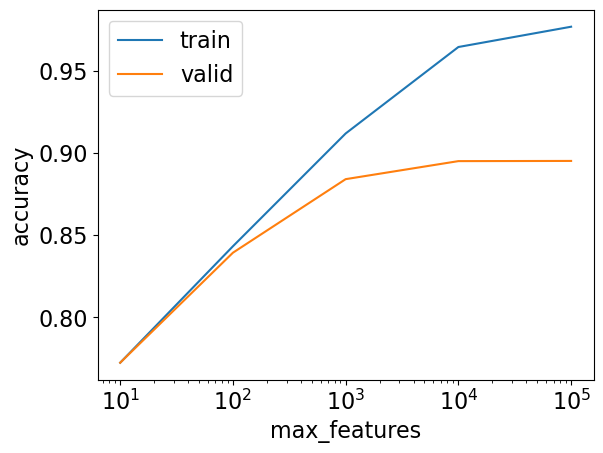

In [19]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    #     print(mf)    
    pipe = make_pipeline(CountVectorizer(stop_words="english", max_features=mf), LogisticRegression(max_iter=1000))
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy");

In [20]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.772506,0.772491
1,100,0.843253,0.839331
2,1000,0.911779,0.884025
3,10000,0.964317,0.894983
4,100000,0.976644,0.895098


<div class="alert alert-warning">

Solution_3.1
    
</div>

A value of 10,000 seems to be the best for max_features. There seems to be no impactful increase in validation accuracy past this number. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.2 Optimizing `C` of `LogisticRegression`

_points:_ 2

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. 

**Your tasks:**

- Based on the plot, what value of `C` seems best? Briefly explain. 

> The code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

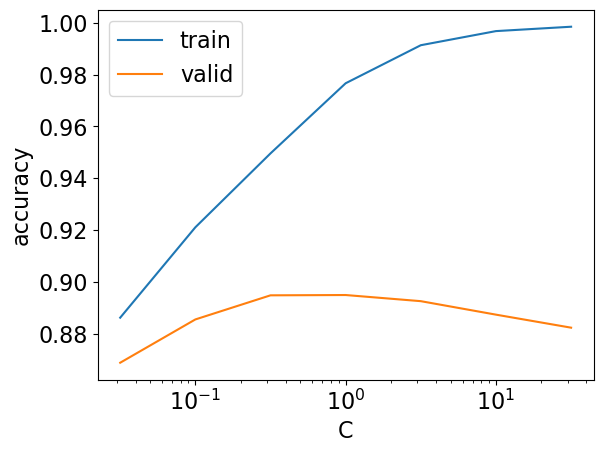

In [21]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-1.5, 2, 0.5)

for C in C_vals:
    #     print(C)
    pipe = make_pipeline(CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000, C=C))    
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [22]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.031623,0.886375,0.869031
1,0.100000,0.921179,0.885698
2,0.316228,0.949640,0.894983
3,1.000000,0.976644,0.895098
4,3.162278,0.991292,0.892734
5,10.000000,0.996727,0.887543
6,31.622777,0.998414,0.882526


<div class="alert alert-warning">

Solution_3.2
    
</div>

A value of 1.0 for C seems to be the best, with no improvements to validation accuracy seen when using higher values

<!-- END QUESTION -->

<br><br>

# 3.3 Hyperparameter optimization 

_points:_ 8

Start with the pipeline `pipe` below.

**Your tasks:**
- Create a `GridSearchCV` object named `grid_search` to jointly optimize `max_features` of `CountVectorizer` and `C` of `LogisticRegression` across all the combinations of values we tried above. 
- What are the best values of `max_features` and `C_vals` according to your grid search? Store them in variables `best_max_features` and `best_C`, respectively.  
- Store the best score returned by the grid search in a variable called `best_score`. 

> The code might be a bit slow here. Setting `n_jobs=-1` should speed it up if you have a multi-core processor.

In [23]:
pipe = make_pipeline(CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000, random_state=123))

<div class="alert alert-warning">

Solution_3.3
    
</div>

In [24]:
param_grid = {
    "countvectorizer__max_features": [100, 200, 400, 800, 1000, 2000],
    "logisticregression__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
}
grid_search = GridSearchCV(pipe, 
                  param_grid = param_grid, 
                  n_jobs=-1, 
                  return_train_score=True
                 )
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=123))]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [100, 200, 400, 800,
                                                           1000, 2000],
                         'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10,
                                                   100]},
             return_train_score=True)

In [25]:
best_score = grid_search.best_score_ 
best_max_features = grid_search.best_params_["countvectorizer__max_features"]
best_C = grid_search.best_params_["logisticregression__C"]
print(best_score, best_max_features, best_C)

0.8897923875432525 2000 1.0


<br><br>

<!-- BEGIN QUESTION -->

### 3.4 Discussion 

_points:_ 4

- Do the best values of hyperparameters found by Grid Search agree with what you found in 3.1 and 3.2? 
- Generally speaking, _should_ these values agree with what you found in parts  3.1 and 3.2? Why or why not? 

<div class="alert alert-warning">

Solution_3.4
    
</div>

The best values for max_features found by grid search does not agree with what I found in 3.1. This could simply be due to the fact that we did not expect enough numbers manually, and simply chose the best one with what we decided to test initially.

The best value for C agrees with what I found in 3.2

Generally, I would expect the values to fall in the same ballpark, as it would be surprising to find completely different values that were not obvious upon manual inspection. However, it is good that GridSearch finds differing values, as it is performing much more extensive and complex evaluation that we are not doing manually. If it came to the exact same conclusions as manual inspection, we might as well not go through the time and effort to use it.

<!-- END QUESTION -->

<br><br>

# 3.5 Test score

_points:_ 2

**Your tasks:**
- Evaluate your final model on the test set. Store the test accuracy in the variable called `test_score`.

<div class="alert alert-warning">

Solution_3.5
    
</div>

In [26]:
pipe = make_pipeline(CountVectorizer(stop_words="english", max_features = best_max_features), LogisticRegression(max_iter=1000, C=best_C))
pipe.fit(X_train, y_train)
test_score = pipe.score(X_test, y_test)
print(test_score)

0.8868983546055667


<br><br>

<!-- BEGIN QUESTION -->

### 3.6 Discussion

_points:_ 2

- How does your test accuracy compare to your validation accuracy? 
- If they are different: do you think this is because you "overfitted on the validation set", or simply random luck?

<div class="alert alert-warning">

Solution_3.6
    
</div>

The test accuracy is very close to our validation accuracy, hovering close to 90%. If they were different, it would not be possible to have overfitted on the validation set, since our cross-validation is not performed on the validation set. However, we could be overfitted on the training data, though I don't think this is likely since we performed hyperparameter optimization. 

<!-- END QUESTION -->

<br><br><br><br>

<!-- BEGIN QUESTION -->

## Exercise 4: Very short answer questions
<hr>

_points:_ 6

Each question is worth 2 points. Max 2 sentences per answer.

1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`? 
2. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.
3. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?

<div class="alert alert-warning">

Solution_4
    
</div>

1. This violates the golden rule of training our model on the test data. We cannot bias the model with data we are planning to test it on.
2. I would choose `predict_proba`, since it still allows us to obtain a prediction but also gives us the confidence of the estimation. `predict` does the same thing but only gives us a label/value. 
3. `RandomizedSearchCV` is faster to perform than `GridSearchCV`. We can also add more parameters to test without affecting the efficiency of the search

<!-- END QUESTION -->

<br><br><br><br>

# Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using [PrairieLearn](https://ca.prairielearn.com/pl/course_instance/6697). Don't forget to rename your file `hw4_sol.ipynb`.

# Congratulations on finishing the homework! 

![](img/eva-well-done.png)

